<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-Data-(Gather)" data-toc-modified-id="Load-Data-(Gather)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data (Gather)</a></span></li><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Data-understanding----EDA" data-toc-modified-id="Data-understanding----EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data understanding  - EDA</a></span><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Missing-values" data-toc-modified-id="Missing-values-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Missing values</a></span><ul class="toc-item"><li><span><a href="#Per-Feature" data-toc-modified-id="Per-Feature-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Per Feature</a></span></li></ul></li><li><span><a href="#Per-Row" data-toc-modified-id="Per-Row-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Per Row</a></span></li></ul></li><li><span><a href="#Data-Preparation-(Preprocessing)" data-toc-modified-id="Data-Preparation-(Preprocessing)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Preparation (Preprocessing)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Create-data-flag-column" data-toc-modified-id="Create-data-flag-column-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Create data flag column</a></span></li></ul></li></ul></li><li><span><a href="#Questions-(Modelling-and-Evaluation)" data-toc-modified-id="Questions-(Modelling-and-Evaluation)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Questions (Modelling and Evaluation)</a></span><ul class="toc-item"><li><span><a href="#Which-proportion-of-developers-works-with-data?" data-toc-modified-id="Which-proportion-of-developers-works-with-data?-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Which proportion of developers works with data?</a></span></li><li><span><a href="#Any-differences-in-working-habits?" data-toc-modified-id="Any-differences-in-working-habits?-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Any differences in working habits?</a></span><ul class="toc-item"><li><span><a href="#Difference-in-remote-working-habits" data-toc-modified-id="Difference-in-remote-working-habits-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Difference in remote working habits</a></span></li><li><span><a href="#Difference-in-working-hours" data-toc-modified-id="Difference-in-working-hours-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Difference in working hours</a></span></li></ul></li><li><span><a href="#Difference-in-job-satisfaction" data-toc-modified-id="Difference-in-job-satisfaction-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Difference in job satisfaction</a></span></li></ul></li><li><span><a href="#References---Sources" data-toc-modified-id="References---Sources-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References - Sources</a></span></li></ul></div>

## Imports

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from IPython.core.display import HTML

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

# Set base plotting style
plt.style.use('seaborn-ticks')
# # Set base plotting size
plt.rcParams['figure.figsize'] = 14, 9
# Magic word for producing visualizations in notebook
%matplotlib inline
# Increase figure resolution for high dpi screens
%config InlineBackend.figure_format = 'retina'
# Autoreload modules
%load_ext autoreload
%autoreload 2

## Load Data (Gather)

In [2]:
df = pd.read_csv('data/survey-results-public.csv')
schema = pd.read_csv('data/survey-results-schema.csv')## Load Data (Gather)

## Helper Functions

In [3]:
def hist_box_plot(x, x_label, y_label, bin_incr):
    '''Take an array as input and draw a histogram with a boxblot above it'''
    f, (ax_box, ax_hist) = plt.subplots(2,
                                        sharex=True,
                                        gridspec_kw={
                                            "height_ratios": (.15, .85)},
                                        figsize=(14, 6))

    sns.boxplot(x, ax=ax_box)
    bins = np.arange(0, x.max() + bin_incr, bin_incr)
    x.hist(grid=False, bins=bins)
    ax_box.set(yticks=[])
    ax_hist.set_ylabel(y_label)
    ax_hist.set_xlabel(x_label)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

def get_description(column_name, schema=schema):
    '''Returns decription on column based on data schema
    
    Parameters
    ----------
    column_name : string 
        the desired columnto return description
    schema : pandas.DataFrame
        the dtaframe containing the data schema to be parsed
        
    Returns
    -------
    desc : string
        the description of the column
            
    '''
    return schema[schema.Column == column_name].Question.values[0]

def print_perc_nans(df, col):
    '''Prints percentage of NaNs in a pandas series'''
    
    print(f'Percentage of NaNs in {col}: ',
          round(df[col].isna().mean() * 100, 2),
          '%')
    
def group(df, group_col, val_col):
    '''groupby and return grouped'''
    props = (df.groupby([group_col])[val_col]
                 .value_counts(normalize=True)
                 .rename('percentage')
                 .mul(100) 
                 .reset_index()
                 .sort_values(val_col))
    return props

def group_plot(df, group_col, val_col, prop=True, orient='h', figsize=(14,8)):
    '''group by group col and val_col and plot a barplot'''
    plt.figure(figsize=(14,8))
    props = (df.groupby([group_col])[val_col]
                 .value_counts(normalize=True)
                 .rename('percentage')
                 .mul(100) 
                 .reset_index()
                 .sort_values(val_col))
    
    order=['Data Science Developer', 'Other Developer']
    
    if orient == 'h':
        p = sns.barplot(y=val_col, x='percentage', hue=group_col, hue_order=order,
                        estimator=np.mean, data=props) 
    else:
        p = sns.barplot(x=val_col, y='percentage', hue=group_col,
                        hue_order=order, estimator=np.mean, data=props) 
        
    plt.legend(title='')
    sns.despine(top=True, right=True, left=False, bottom=False);
    
def Groupby_OneCol_comp_plot(df, col, plt_style = 'seaborn-ticks', color_palette = "pastel", title=''):
    '''
    Group by col1, sort by size , return and plot the dataframe with a bar and pie plot
    '''
    opacity=0.85
    gr=pd.DataFrame()
    gr['{} No'.format(col)] = df.groupby(col).size()
    gr['{} Ratio'.format(col)] = np.round(gr['{} No'.format(col)].divide(gr['{} No'.format(col)].sum())*100,0)
    
    print ('Total No. of {}:{}'.format(col,gr['{} No'.format(col)].sum()))
    
    plt.style.use(plt_style)
    sns.set_palette(sns.color_palette(color_palette))
    
    
    fig=plt.figure()
    plt.axis('off')

    fig.add_subplot(121)
    
    ax=gr['{} No'.format(col)].plot(kind='bar', title='{} Counts'.format(title), figsize=(16,8),
                                    color=sns.color_palette(),
                                    alpha=opacity)
    _ = plt.setp(ax.get_xticklabels(), rotation=0)
    for p in ax.patches: ax.annotate(np.round(p.get_height(),decimals=2),
                                     (p.get_x()+p.get_width()/2., p.get_height()),
                                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    ax.get_yaxis().set_ticks([])
    plt.xlabel('')

    fig.add_subplot(122)
    plt.axis('off')
    p = gr.loc[:,'{} Ratio'.format(col)].plot(kind= 'pie',
                                     autopct='%1.1f%%',shadow=False,
                                     title='{} Ratio'.format(title), legend=False, labels=None);

    sns.despine(top=True, right=True, left=True, bottom=False);

## Data understanding  - EDA

### Overview

In [4]:
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(51392, 154)

In [6]:
schema.head()

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


### Missing values

In [7]:
# How many nans?
print('Total percentage of Nans: ',
      round(df.isnull().sum().sum() / np.product(df.shape) * 100, 2),
      '%')

Total percentage of Nans:  45.32 %


####  Per Feature

In [8]:
feat_nan_perc = df.isnull().mean()

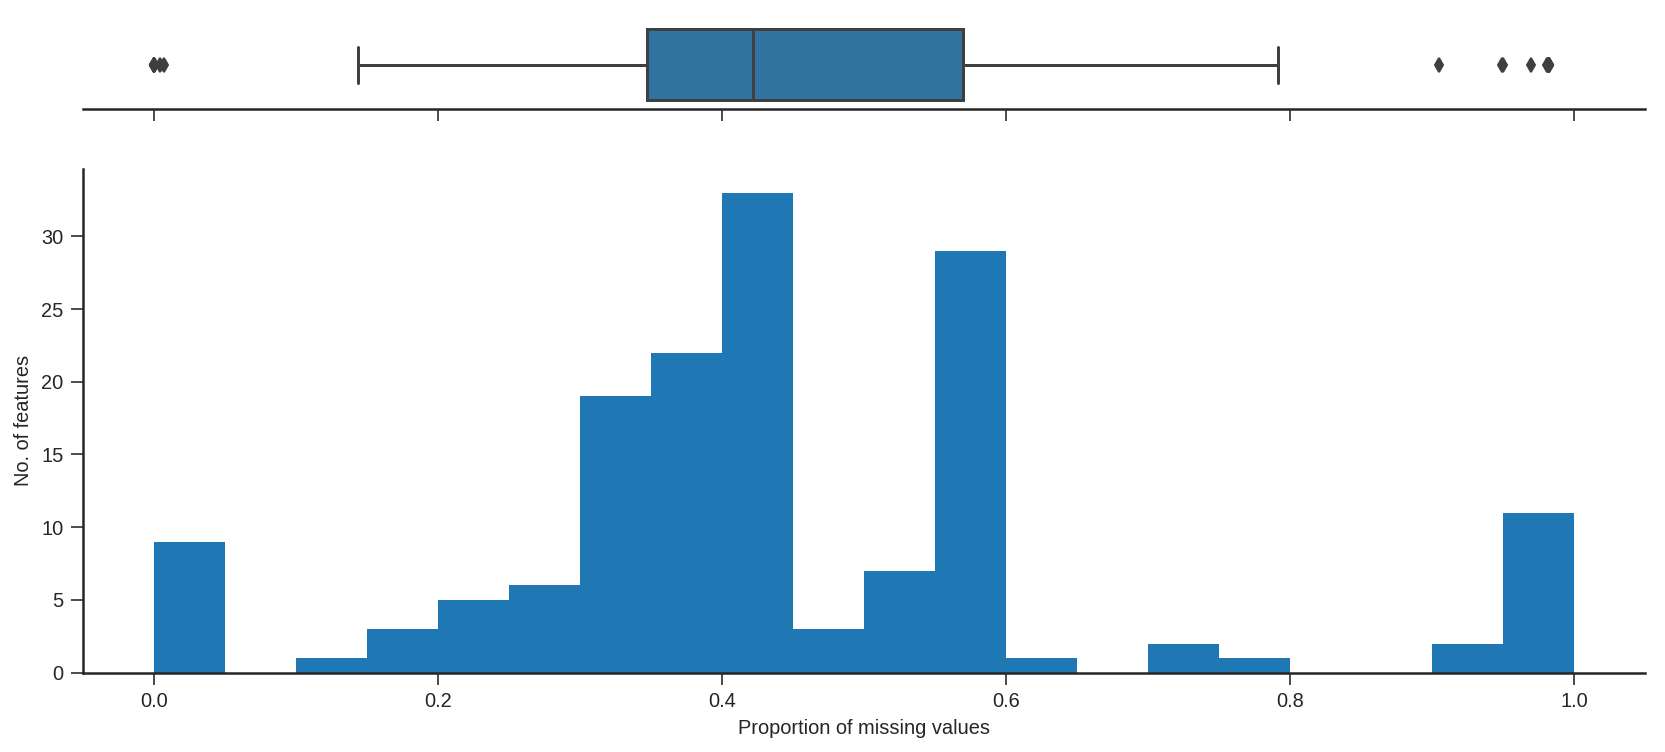

In [9]:
hist_box_plot(feat_nan_perc, x_label='Proportion of missing values', y_label='No. of features', bin_incr=0.05);

The biggest percentage of columns has 30 - 60 % missing values with two peaks at around 40% and just below 60%. There is also a spike of features with a percentage of missing values close to 100 %. Features with a percentage of missing values above 80% ca be considered outliers and not containing enough usefull infomation and will be dropped for this analysis.

In [10]:
df.isnull().mean().sort_values()[-20::]

InfluenceConsultants    0.580771
Currency                0.583437
HoursPerWeek            0.599159
HaveWorkedFramework     0.606378
Overpaid                0.739512
Salary                  0.749163
WebDeveloperType        0.791874
NonDeveloperType        0.904849
TimeAfterBootcamp       0.949370
ExpectedSalary          0.950070
MobileDeveloperType     0.969781
YearsCodedJobPast       0.981048
ExCoderSkills           0.981807
ExCoderActive           0.981904
ExCoderBelonged         0.981943
ExCoderBalance          0.982040
ExCoderReturn           0.982040
ExCoderWillNotCode      0.982059
ExCoderNotForMe         0.982079
ExCoder10Years          0.982157
dtype: float64

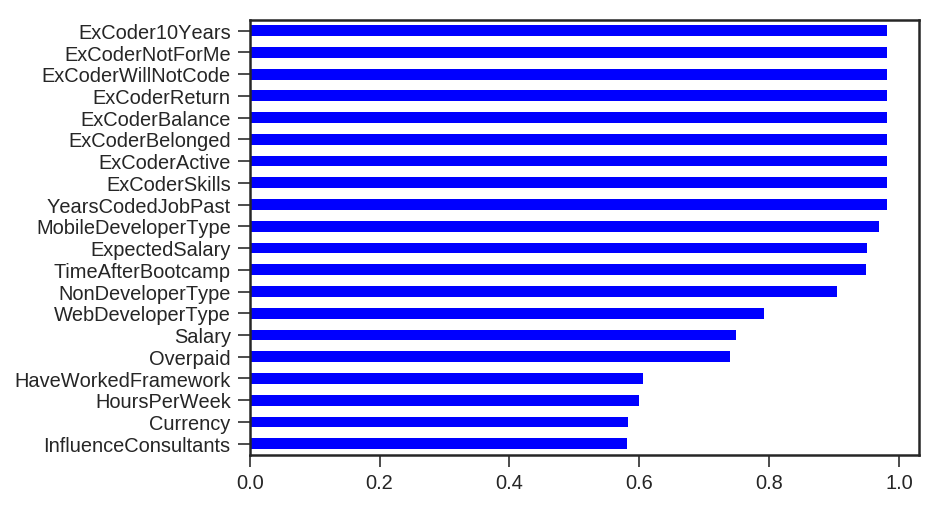

In [11]:
df.isnull().mean().sort_values()[-20::].plot(kind='barh', color='b');

In [12]:
high_nan_features = df.columns[df.isnull().mean() > 0.8]
high_nan_features

Index(['YearsCodedJobPast', 'MobileDeveloperType', 'NonDeveloperType',
       'ExCoderReturn', 'ExCoderNotForMe', 'ExCoderBalance', 'ExCoder10Years',
       'ExCoderBelonged', 'ExCoderSkills', 'ExCoderWillNotCode',
       'ExCoderActive', 'TimeAfterBootcamp', 'ExpectedSalary'],
      dtype='object')

In [13]:
len(high_nan_features)

13

There are 13 features with NaNs above 80% - 6 of them refer to the `Excoder` category. `ExpectedSalary` has 95% missing values.

### Per Row

In [14]:
row_nan_perc = df.isnull().mean(axis=1) 

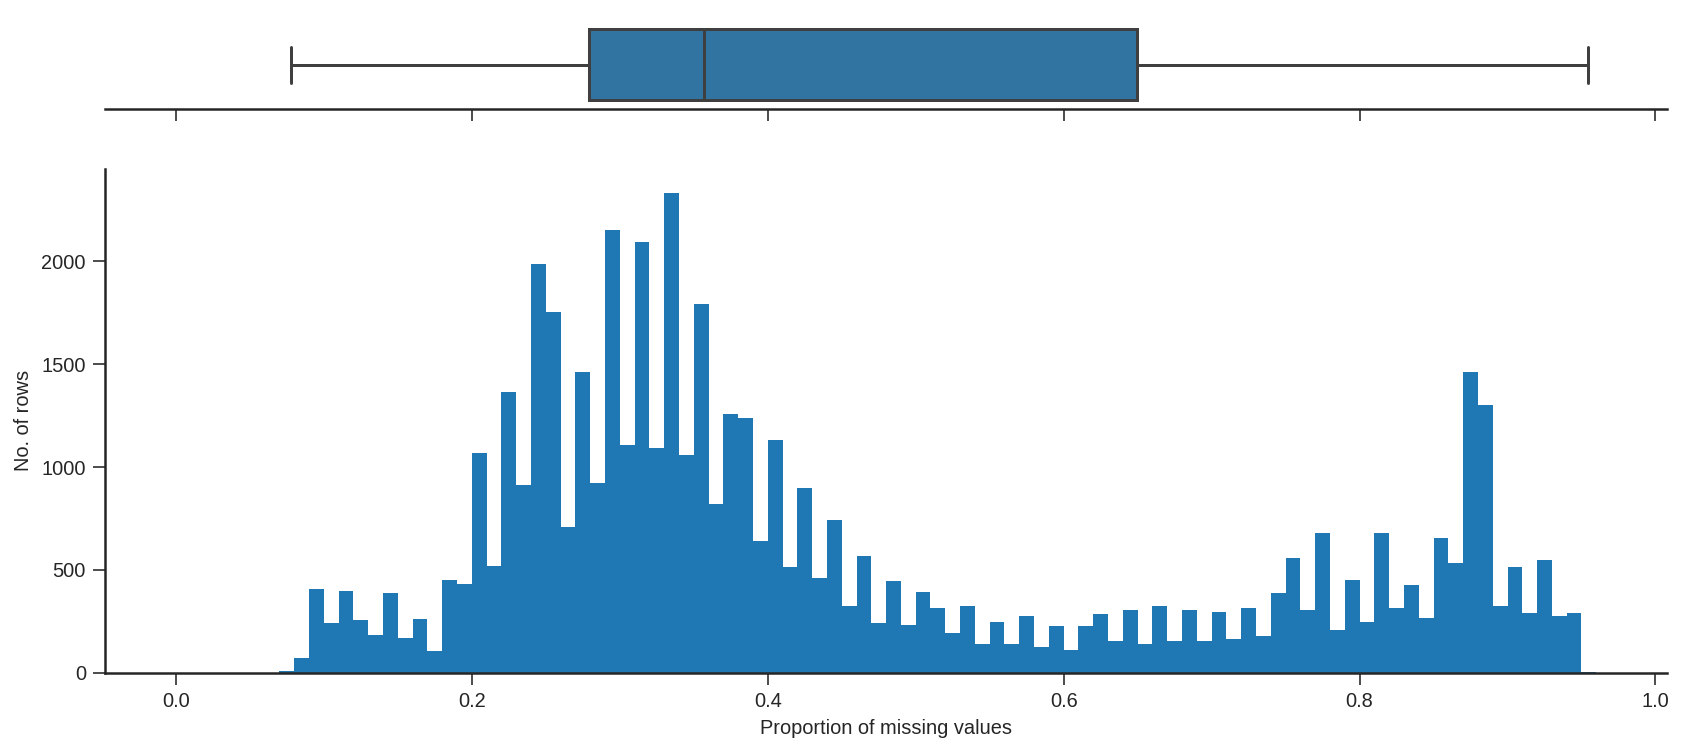

In [15]:
hist_box_plot(row_nan_perc, x_label='Proportion of missing values', y_label='No. of rows', bin_incr=0.01);

Looks like a bimodal distribution with one distribution centered around the median of 30% missing values and the smaller one around 90% of missing values

## Data Preparation (Preprocessing)

We will drop the features with a percentage of NaNs over 80% and keep the rows treating each feature we exam below individually.

In [16]:
# Drop the high NaN features
high_nan_features = df.columns[df.isnull().mean() > 0.8]
df = df.drop(columns=high_nan_features)

In [17]:
df.shape

(51392, 141)

#### Create data flag column

In [18]:
df.Professional.unique()

array(['Student', 'Professional developer',
       'Professional non-developer who sometimes writes code',
       'Used to be a professional developer', 'None of these'],
      dtype=object)

In [19]:
get_description('DeveloperType')

'Which of the following best describe you?'

The `DeveloperType` is the column of interest here. We will filter all the entries that contaiin the word Data or Machine to get the data professionals of all types.  
It could be interesting to see the following:
- What kind of jobs do data professionals do and at which percentages?
- Which are the most common job descriptons that they declare along with their data proffesion? 
- Is there a special meaning to which job is mentioned first?

In [20]:
devtypes = []
for dev in df.DeveloperType.str.split(';').dropna():
    for devtype in dev:
        devtype = devtype.strip()
        if devtype not in devtypes:
                devtypes.append(devtype)

In [21]:
devtypes 

['Other',
 'Mobile developer',
 'Graphics programming',
 'Desktop applications developer',
 'Web developer',
 'Embedded applications/devices developer',
 'DevOps specialist',
 'Quality assurance engineer',
 'Data scientist',
 'Machine learning specialist',
 'Developer with a statistics or mathematics background',
 'Database administrator',
 'Systems administrator',
 'Graphic designer']

Let's first see which are the possible values here by slitting the strings

In [22]:
data_devtypes = set([dev.strip() for dev in devtypes if 'Data scientist' in dev
                                        or 'Machine' in dev
                                        or 'statistics' in dev])

In [23]:
data_devtypes

{'Data scientist',
 'Developer with a statistics or mathematics background',
 'Machine learning specialist'}

Replace all the Nones with np.nan for consistency

In [24]:
dev_types = df.DeveloperType.str.split(';', expand = True).apply(lambda x: x.str.strip()).replace({None: np.nan})

Let's create a flag for `data scientists/machine learning specialists/Developer with a statistics or mathematics background`

In [25]:
# Create a flag column for data professionals
df['is_data'] = 0
for col in dev_types.columns:
    df.loc[dev_types[col].isin(data_devtypes), 'is_data'] = 1

## Questions (Modelling and Evaluation)

### Which proportion of developers works with data?

In [26]:
df.is_data.value_counts()

0    45039
1     6353
Name: is_data, dtype: int64

Look like we have found 6353 individuals that have put data jobs in any position.


In [27]:
# Sanity Test
df[['DeveloperType', 'is_data']].sample(10)

,DeveloperType,is_data
16811,Web developer,0
9326,Web developer; Desktop applications developer,0
10730,Web developer; Developer with a statistics or ...,1
29443,NaN,0
38499,NaN,0
3236,Web developer; Mobile developer,0
37629,NaN,0
24458,NaN,0
19225,DevOps specialist,0
17473,Web developer; Database administrator,0


In [28]:
# Rename for better plotting
df['is_data'] = df.is_data.map({0:'Other Developer', 1: 'Data Science Developer'})

Total No. of is_data:51392


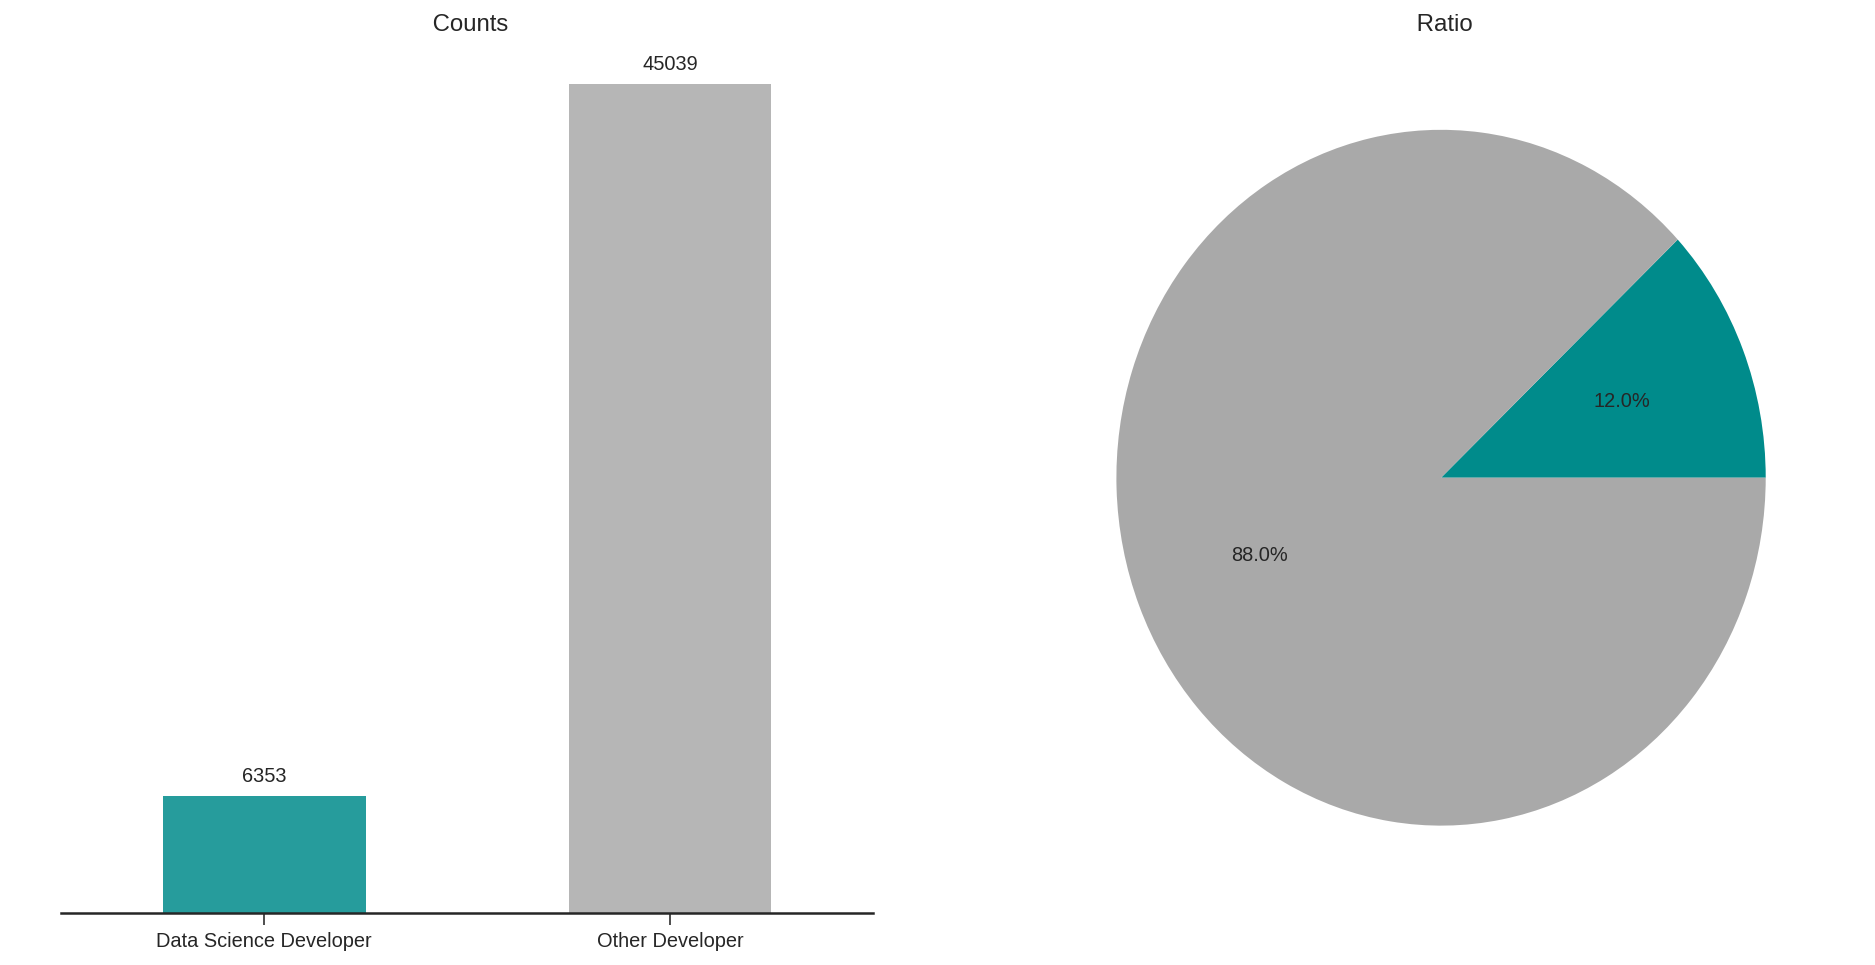

In [29]:
Groupby_OneCol_comp_plot(df, 'is_data', plt_style = 'seaborn-ticks', color_palette = ['darkcyan','darkgrey'], title='')

In [30]:
# Create a developer and a data science dataset
df_dev = df[df.is_data == 'Other Developer']
df_ds = df[df.is_data != 'Other Developer']

In [31]:
df.columns

Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
       'CompanySize',
       ...
       'StackOverflowMakeMoney', 'Gender', 'HighestEducationParents', 'Race',
       'SurveyLong', 'QuestionsInteresting', 'QuestionsConfusing',
       'InterestedAnswers', 'Salary', 'is_data'],
      dtype='object', length=142)

### Any differences in working habits?

#### Difference in remote working habits

In [32]:
get_description('HomeRemote')

'How often do you work from home or remotely?'

In [33]:
print_perc_nans(df, 'HomeRemote')

Percentage of NaNs in HomeRemote:  14.37 %


We will not use the rows with missing data as they are not included in the `groupby` operations.

In [34]:
df.HomeRemote.value_counts()

A few days each month                                      15454
Never                                                      13975
All or almost all the time (I'm full-time remote)           4905
Less than half the time, but at least one day each week     4147
More than half, but not all, the time                       1909
It's complicated                                            1849
About half the time                                         1769
Name: HomeRemote, dtype: int64

In [35]:
group(df, 'is_data', 'HomeRemote')

,is_data,HomeRemote,percentage
0,Data Science Developer,A few days each month,37.772712
7,Other Developer,A few days each month,34.685470
5,Data Science Developer,About half the time,4.265711
13,Other Developer,About half the time,3.979824
2,Data Science Developer,All or almost all the time (I'm full-time remote),11.738847
9,Other Developer,All or almost all the time (I'm full-time remote),11.049490
6,Data Science Developer,It's complicated,4.102898
12,Other Developer,It's complicated,4.217504
3,Data Science Developer,"Less than half the time, but at least one day ...",10.794529
10,Other Developer,"Less than half the time, but at least one day ...",9.200866


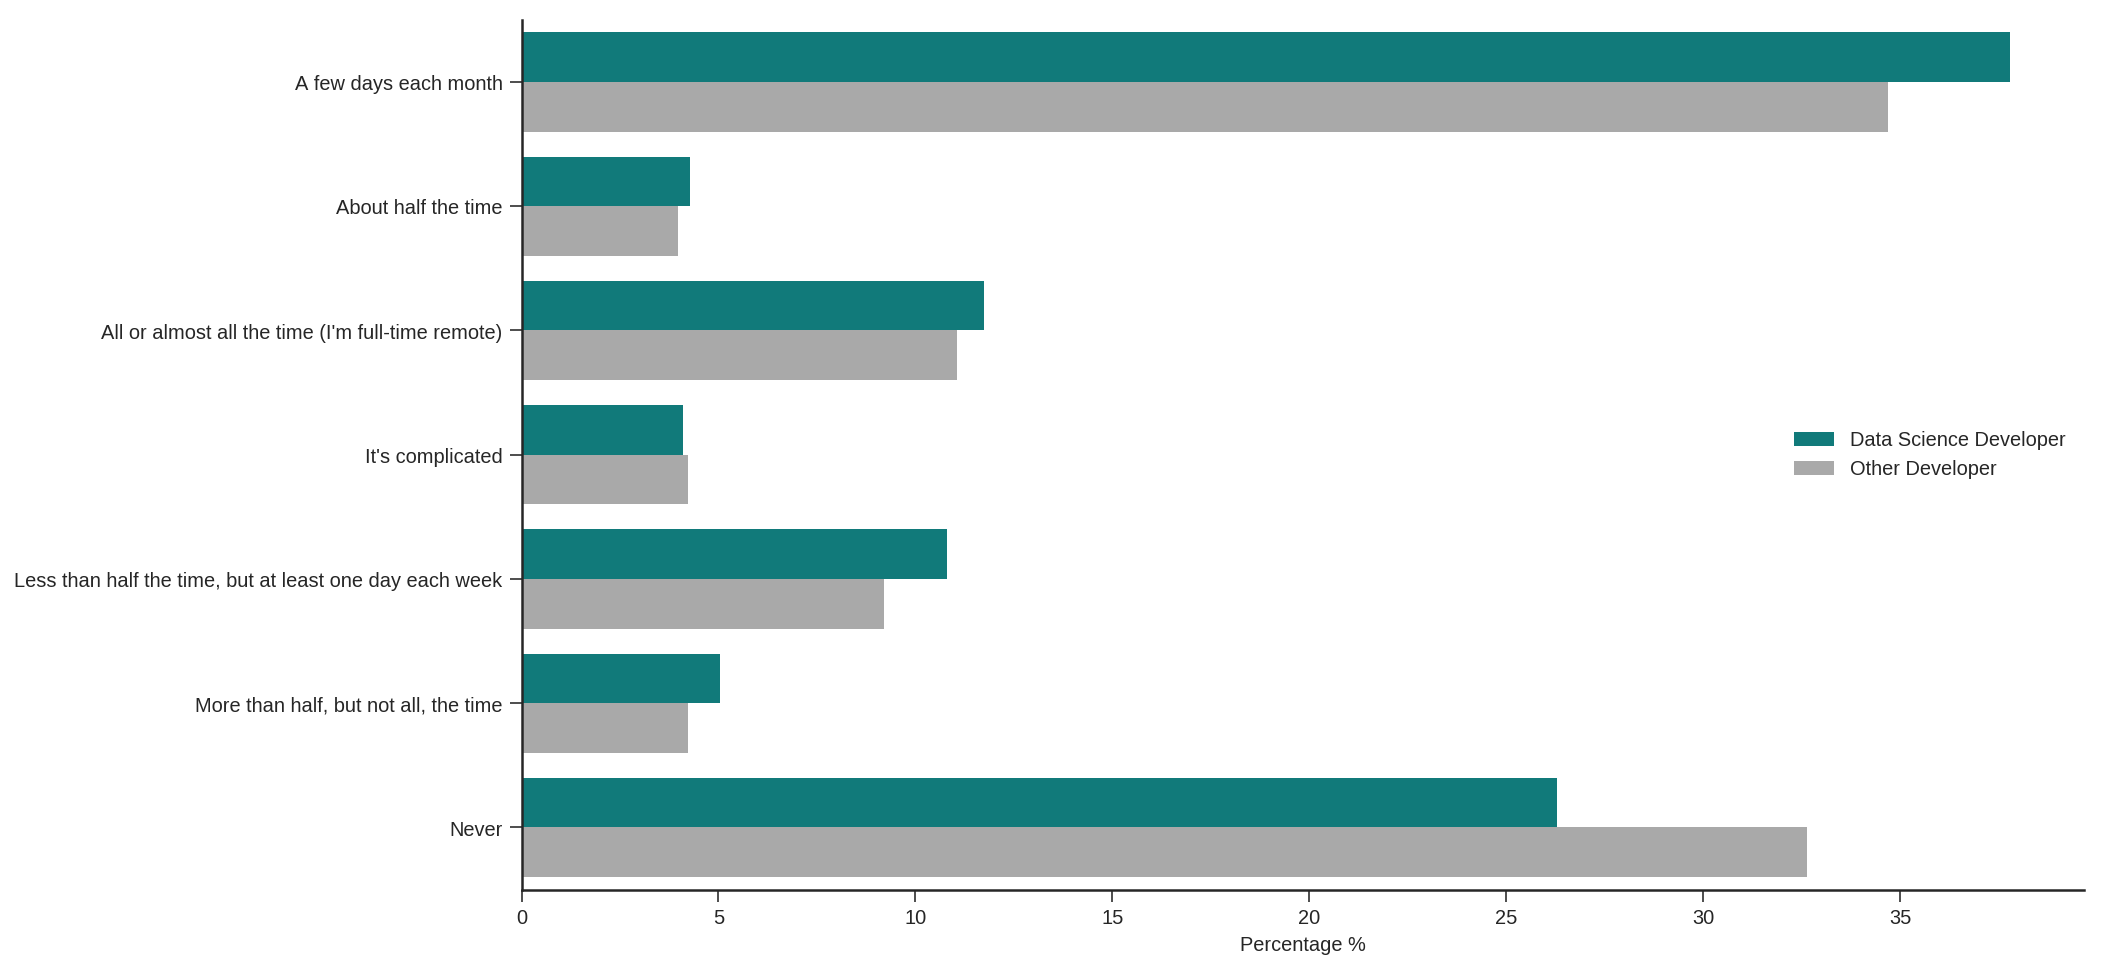

In [36]:
group_plot(df, 'is_data', 'HomeRemote', prop=True, orient='h')
plt.xlabel('Percentage %')
plt.ylabel('');

Data scientists seem to have slightly better working habits with 5% more working remotely a few days per month and 5 % less that respond never. Let's see if that has something to  do with job satisfaction.

#### Difference in working hours

In [37]:
get_description('ProgramHobby')

'Do you program as a hobby or contribute to open source projects?'

In [38]:
print_perc_nans(df, 'ProgramHobby')

Percentage of NaNs in ProgramHobby:  0.0 %


In [39]:
df.ProgramHobby.value_counts()

Yes, I program as a hobby                    24801
Yes, both                                    13756
No                                            9787
Yes, I contribute to open source projects     3048
Name: ProgramHobby, dtype: int64

In [40]:
group(df, 'is_data', 'ProgramHobby')

,is_data,ProgramHobby,percentage
2,Data Science Developer,No,16.747993
6,Other Developer,No,19.367659
3,Data Science Developer,"Yes, I contribute to open source projects",7.256414
7,Other Developer,"Yes, I contribute to open source projects",5.743911
0,Data Science Developer,"Yes, I program as a hobby",42.531088
4,Other Developer,"Yes, I program as a hobby",49.066365
1,Data Science Developer,"Yes, both",33.464505
5,Other Developer,"Yes, both",25.822065


In [41]:
# Tota; number of ds devs that program out of work
group(df, 'is_data', 'ProgramHobby').iloc[:, -1][::2][1:].sum()

83.25200692586179

In [42]:
# Tota; number of other devs that program out of work
group(df, 'is_data', 'ProgramHobby').iloc[:, -1][1:][::2][1:].sum()

80.63234086014344

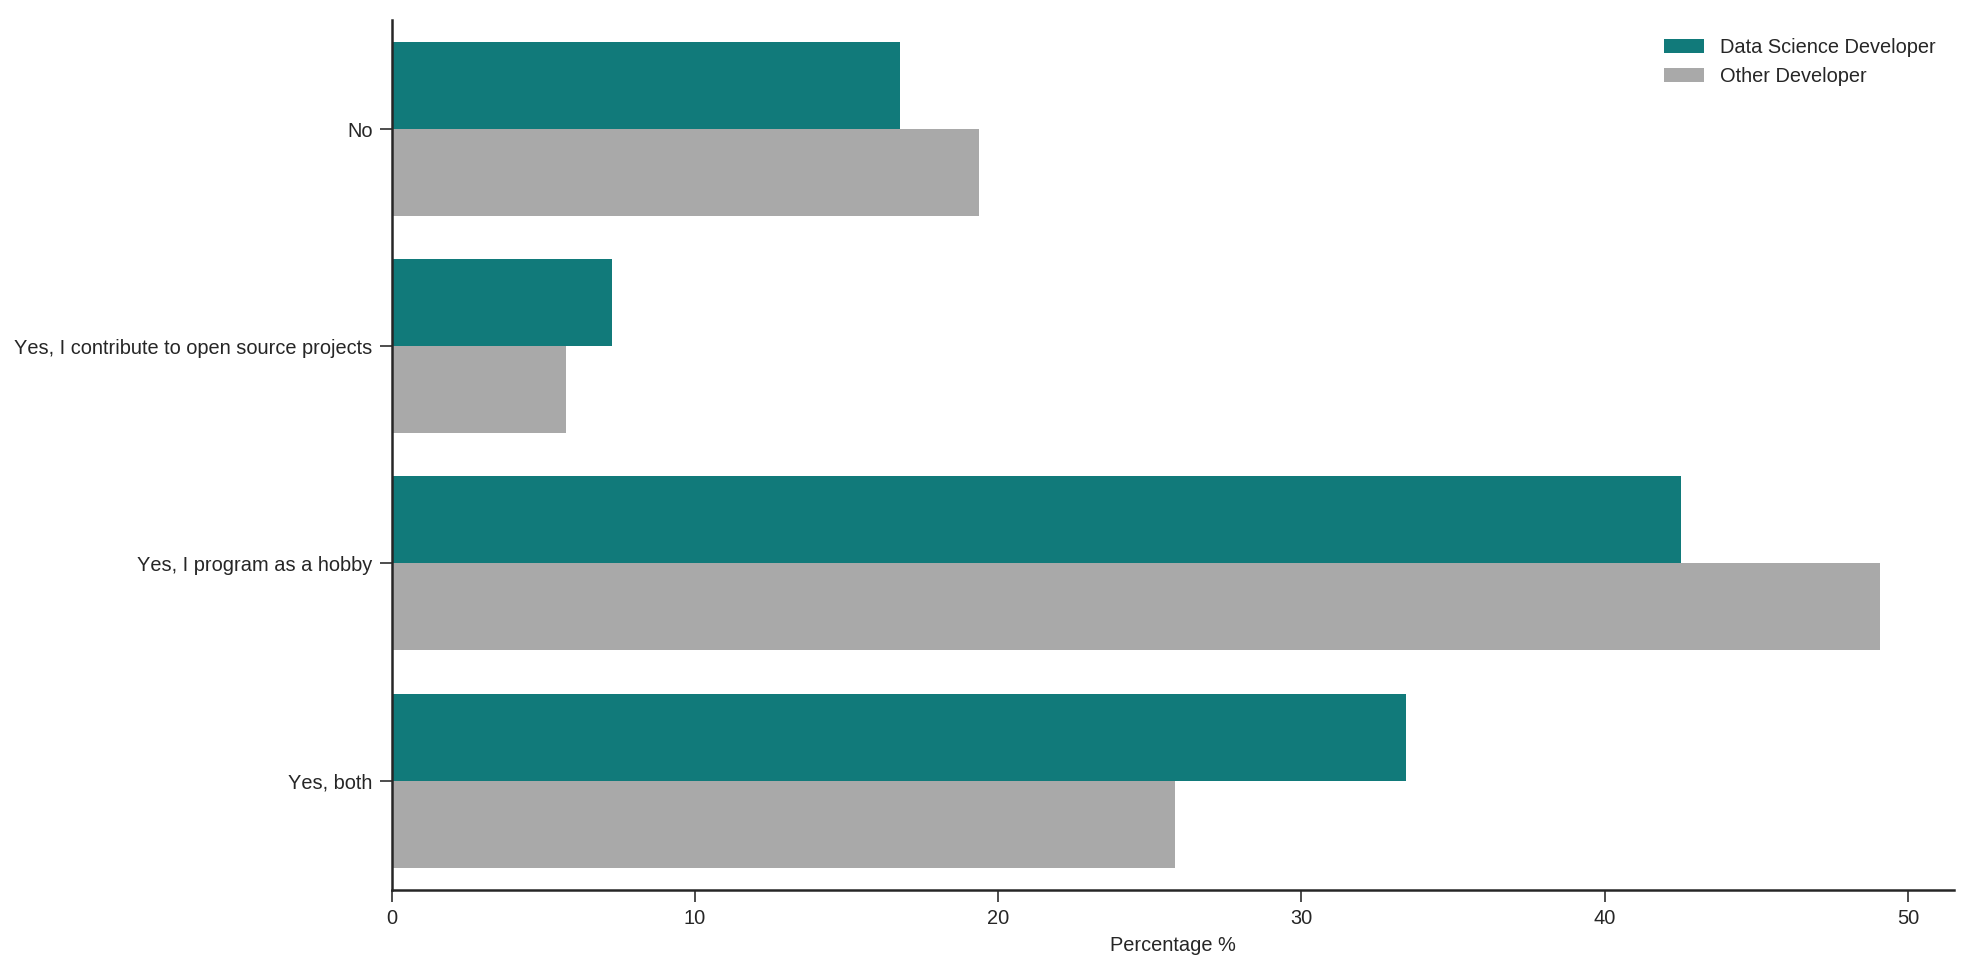

In [43]:
group_plot(df, 'is_data', 'ProgramHobby', prop=True, orient='h')
plt.xlabel('Percentage %')
plt.ylabel('');

### Difference in job satisfaction

In [44]:
get_description('JobSatisfaction')

'Job satisfaction rating'

In [45]:
print_perc_nans(df, 'ProgramHobby')

Percentage of NaNs in ProgramHobby:  0.0 %


In [46]:
df.JobSatisfaction.value_counts()

8.0     8983
7.0     7969
9.0     5573
6.0     4726
10.0    4148
5.0     3749
4.0     1865
3.0     1635
2.0      888
0.0      467
1.0      373
Name: JobSatisfaction, dtype: int64

In [47]:
group(df, 'is_data', 'JobSatisfaction')

,is_data,JobSatisfaction,percentage
20,Other Developer,0.0,1.104763
9,Data Science Developer,0.0,1.449753
10,Data Science Developer,1.0,0.708402
21,Other Developer,1.0,0.961931
8,Data Science Developer,2.0,1.943987
19,Other Developer,2.0,2.244505
7,Data Science Developer,3.0,3.690280
18,Other Developer,3.0,4.112983
6,Data Science Developer,4.0,4.052718
17,Other Developer,4.0,4.719291


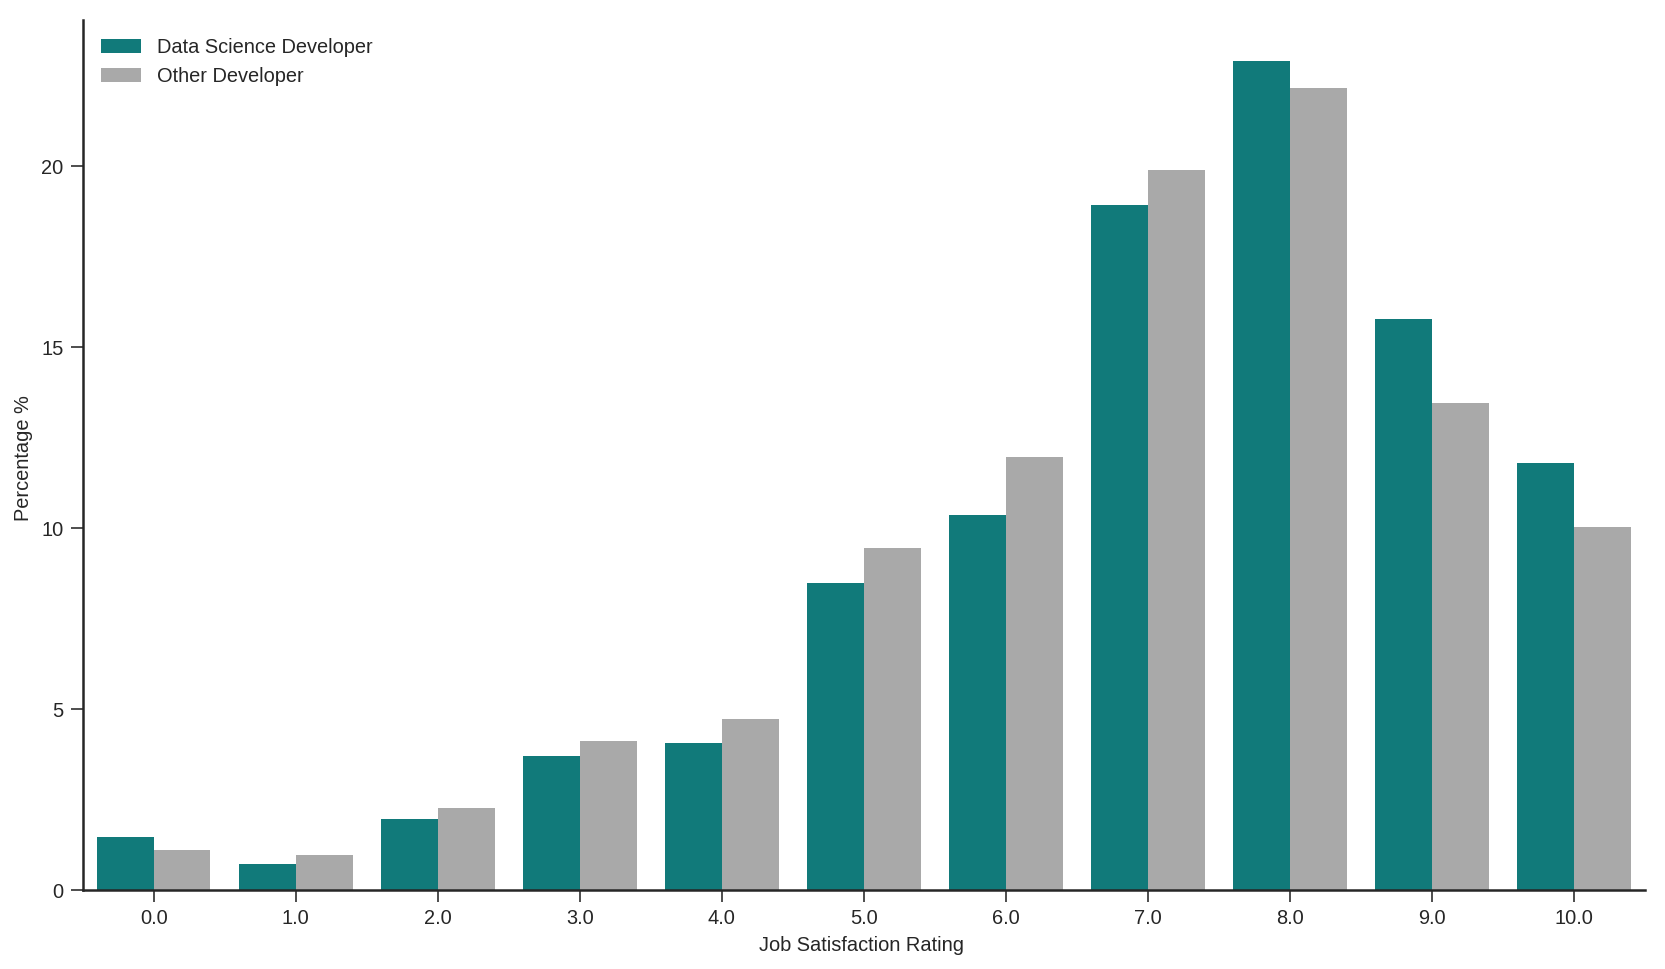

In [48]:
group_plot(df, 'is_data', 'JobSatisfaction', orient='v')
plt.xlabel('Job Satisfaction Rating ')
plt.ylabel('Percentage % ')
plt.legend(title='', loc='upper left');

In [49]:
av_job_sat = df.groupby(['is_data'])['JobSatisfaction'].mean()
av_job_sat

is_data
Data Science Developer    7.114333
Other Developer           6.929254
Name: JobSatisfaction, dtype: float64

In [50]:
(av_job_sat.diff()[-1] / av_job_sat[1]) * 100

-2.670971749462139

Average job satisfaction is 7.11 for DS developers, compared to  6.93 to other developers which is a small difference of 2.67 %. Let's check for significance in this results.

In [51]:
from scipy.stats import chi2_contingency

cont_table = np.array([df_dev.JobSatisfaction.value_counts(),
                       df_ds.JobSatisfaction.value_counts()]              
                     )
chi2, p, dof, ex = chi2_contingency(cont_table)

print(f' chi2: {chi2}\n p: {p}\n dof: {dof}\n ex: {ex}')

 chi2: 47.80191282167782
 p: 6.745505774525362e-07
 dof: 10
 ex: [[7632.52422231 6770.96577175 4735.17282544 4089.4288191  3450.48211809
  3185.38721022 1584.62180503 1389.1992768   754.50089162  396.79269863
   316.92436101]
 [1350.47577769 1198.03422825  837.82717456  723.5711809   610.51788191
   563.61278978  280.37819497  245.8007232   133.49910838   70.20730137
    56.07563899]]


We perform a `Chi-Square Test for Independence`[[1]](#[1]) to determine whether the Developer type( Data science or other) is related to Job satisfaction.

`Ho`: The developer type and job satisfaction are independent (Knowing the level of Variable A does not help you predict the level of Variable B).

`Ha`: The developer type and job satisfaction are **not** independent(Knowing the level of Variable A does help you predict the level of Variable B).

`p_value` is < 0.05. The P-value here is the probability of observing a sample statistic as extreme as the test statistic. If the sample findings are unlikely, given the null hypothesis, the researcher rejects the null hypothesis.

We reject the null hypothesis and conclude that Variable A and Variable B are **not independent** and thus, we conclude that there is a relationship between watching the developer type (data scientist or other developer) and job satisfaction

It seems that working as a data is a good predictor of relative job satisfaction.

## References - Sources

[1]<a name='[1]'></a>:<https://stattrek.com/chi-square-test/independence.aspx>  
[2]<a name='[2]'></a>:<https://stackoverflow.com/questions/28468584/seaborn-factorplot-set-series-order-of-display-in-legend>  
[3]<a name='[3]'></a>:https://medium.com/@josh_2774/how-do-you-become-a-developer-5ef1c1c68711  
[4]<a name='[4]'></a>https://www.kaggle.com/stackoverflow/so-survey-20171  